<a href="https://colab.research.google.com/github/ggomes88/PythonFinance/blob/main/Clustering_IBRA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **1. DEFININDO O PROBLEMA**

O Objetivo deste estudo é encontrar ativos semelhantes dentro do índice IBRA da B3 e assim encontrar pares de ativos para uma estratégia de Pair Trading.

Pair trading é uma estratégia de arbritragem estatística na qual um par de ações é negociado sem levar em conta a tendência do mercado.

 O IBrA é o indicador do desempenho médio das cotações de todos os ativos negociados no mercado a vista (lote-padrão) da B3 que atendam a critérios mínimos de liquidez e presença em pregão, de forma a oferecer uma visão ampla do mercado acionário.

Para essa análise iremos utilizar dados obtivos pela API do Yahoo Finance e bibliotecas do Python voltadas para Machine LEarning e Estatística


#**2. Carregando as Bibliotecas do Python e os Dados da Yahoo Finance**

### **2.1 Carregando as bibliotecas**

In [4]:
# Carregando Bibliotecas do Python

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas import read_csv, set_option
from pandas.plotting import scatter_matrix
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import datetime as dt
import pandas_datareader as dr
!pip install yfinance
import yfinance as yf

#Importando os Algoritmos de Machine LEarning
from sklearn.cluster import KMeans, AgglomerativeClustering,AffinityPropagation, DBSCAN
from scipy.cluster.hierarchy import fcluster
from scipy.cluster.hierarchy import dendrogram, linkage, cophenet
from scipy.spatial.distance import pdist
from sklearn.metrics import adjusted_mutual_info_score
from sklearn import cluster, covariance, manifold

#Outros pacotes
import matplotlib.ticker as ticker
from itertools import cycle

[*********************100%***********************]  178 of 178 completed


pandas.core.frame.DataFrame

### **2.2 Carregando os dados**
Para essa análise iremos utilizar o período de janeiro de 2018 a julho de 2021.
Utilizei um csv contendo todos os ativos do IBRA que baixei direto do site da B3 e converti para a nomenclatura utilizada pelo Yahoo Finance. Transformei esses dados em lista para poder utilizar como argumento para a API do Yahoo Finance. Após baixar os dados, criei um dataset contendo apenas os preços de fechamento dos ativos.

In [50]:
#Baixando lista de ativos integrantes do IBRA do CSV com a nomenclatura do Yahoo Finance

ibra = pd.read_csv('ibra.csv',header=None)

#Convertendo dataframe para lista
ibra = ibra[0].values.tolist()

#Baixando dados do yfinance
inicio=dt.datetime(2018,1,1)
fim=dt.datetime(2021,7,1)
df=yf.download(ibra,inicio,fim)

#Limpando o DF para usar apenas os preços fechamento do dia
dataset = df['Adj Close']
type(dataset)

[*********************100%***********************]  178 of 178 completed


pandas.core.frame.DataFrame

# 3. Análise Exploratória

178 ativos foram baixados do Yahoo Finance, com 866 dias de negociação:

In [52]:
dataset.shape

(866, 178)

Vemos que alguns ativos não possuem dados em algumas datas. Podem ser ativos que foram adicionados após 2018 ou ativos que não constam na base de dados

In [8]:
set_option('display.width', 100)
dataset.head(5)

,AALR3.SA,ABCB4.SA,ABEV3.SA,AERI3.SA,AESB3.SA,AGRO3.SA,ALPA4.SA,ALSO3.SA,ALUP11.SA,AMAR3.SA,AMBP3.SA,ANIM3.SA,ARZZ3.SA,ASAI3.SA,AZUL4.SA,B3SA3.SA,BBAS3.SA,BBDC3.SA,BBDC4.SA,BBSE3.SA,BEEF3.SA,BIDI11.SA,BIDI4.SA,BKBR3.SA,BMGB4.SA,BPAC11.SA,BPAN4.SA,BRAP4.SA,BRDT3.SA,BRFS3.SA,BRKM5.SA,BRML3.SA,BRPR3.SA,BRSR6.SA,BTOW3.SA,CAML3.SA,CASH3.SA,CCRO3.SA,CEAB3.SA,CESP6.SA,...,RENT3.SA,ROMI3.SA,RRRP3.SA,SANB11.SA,SAPR11.SA,SAPR4.SA,SBFG3.SA,SBSP3.SA,SEER3.SA,SEQL3.SA,SIMH3.SA,SLCE3.SA,SMTO3.SA,SOMA3.SA,SQIA3.SA,STBP3.SA,SULA11.SA,SUZB3.SA,TAEE11.SA,TASA4.SA,TCSA3.SA,TEND3.SA,TGMA3.SA,TIMS3.SA,TOTS3.SA,TRIS3.SA,TRPL4.SA,TUPY3.SA,UGPA3.SA,UNIP6.SA,USIM5.SA,VALE3.SA,VIVA3.SA,VIVT3.SA,VLID3.SA,VULC3.SA,VVAR3.SA,WEGE3.SA,WIZS3.SA,YDUQ3.SA
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2018-01-02,14.740,13.700,19.845,NaN,NaN,11.014,13.623,23.959,16.258,7.79,NaN,9.389,52.693,NaN,27.15,6.783,27.436,17.854,20.857,21.278,9.731,NaN,NaN,17.547,NaN,4.155,1.737,24.785,NaN,37.27,38.076,11.447,9.974,11.800,19.768,7.001,NaN,14.437,NaN,10.673,...,21.001,4.678,NaN,26.981,16.547,3.129,NaN,31.416,26.666,NaN,NaN,10.279,17.759,NaN,6.566,3.398,15.229,18.298,14.677,2.10,21.1,9.282,17.286,11.860,9.744,1.802,11.483,16.589,35.326,11.076,9.256,35.182,NaN,30.851,17.312,9.29,7.699,9.183,8.607,29.988
2018-01-03,14.810,13.758,19.890,NaN,NaN,11.005,13.290,24.141,16.134,8.30,NaN,9.454,54.285,NaN,27.06,6.899,27.786,17.930,20.952,21.293,9.660,NaN,NaN,17.726,NaN,4.195,1.755,25.019,NaN,37.00,37.755,11.410,10.288,11.855,19.610,6.992,NaN,14.332,NaN,10.624,...,21.287,5.009,NaN,26.758,16.404,3.118,NaN,30.853,26.573,NaN,NaN,10.369,17.777,NaN,6.616,3.398,15.657,18.162,14.698,2.01,21.9,9.254,17.286,11.869,9.951,1.810,11.249,16.713,34.977,11.886,9.564,34.971,NaN,29.957,17.574,9.75,7.739,9.044,8.536,30.015
2018-01-04,14.938,13.716,19.781,NaN,NaN,11.361,13.274,24.083,15.984,8.20,NaN,9.553,55.997,NaN,27.23,6.943,28.053,18.256,21.296,21.337,9.624,NaN,NaN,17.726,NaN,4.210,1.728,25.730,NaN,37.40,38.328,11.548,10.430,11.927,20.144,7.162,NaN,14.385,NaN,10.543,...,21.591,4.969,NaN,27.080,16.272,3.076,NaN,30.254,26.987,NaN,NaN,10.328,17.749,NaN,6.596,3.348,15.698,18.210,14.465,2.02,21.9,9.212,17.951,11.815,9.890,1.862,10.941,17.315,35.386,11.760,10.104,35.115,NaN,30.285,17.574,10.00,7.798,8.956,8.465,29.891
2018-01-05,14.899,13.915,19.854,NaN,NaN,11.596,13.506,24.112,16.028,8.19,NaN,9.652,54.116,NaN,27.20,7.044,28.053,18.262,21.416,21.478,9.731,NaN,NaN,17.627,NaN,4.280,1.774,26.350,NaN,39.24,39.257,11.585,10.620,12.083,19.768,7.323,NaN,14.446,NaN,10.592,...,21.278,4.951,NaN,27.368,16.395,3.129,NaN,30.599,26.649,NaN,NaN,10.521,17.554,NaN,6.628,3.468,15.747,18.162,14.534,2.01,21.7,9.451,18.150,11.914,10.103,1.867,11.116,17.332,35.459,11.946,9.670,35.663,NaN,30.359,17.538,10.00,7.549,8.992,8.586,29.483
2018-01-08,14.641,14.047,19.817,NaN,NaN,11.648,13.236,23.442,15.940,8.33,NaN,9.718,53.452,NaN,26.91,7.077,28.119,18.262,21.410,21.604,9.401,NaN,NaN,17.627,NaN,4.332,1.801,26.810,NaN,39.70,39.326,11.539,10.649,12.286,19.610,7.314,NaN,14.245,NaN,10.592,...,21.176,4.940,NaN,27.852,16.297,3.129,NaN,31.225,26.700,NaN,NaN,10.465,17.461,NaN,6.690,3.348,15.517,18.600,14.465,1.98,21.5,9.306,18.150,11.752,10.097,1.889,11.058,16.996,35.707,12.484,9.776,36.456,NaN,30.680,17.493,10.05,7.679,9.066,8.550,29.590


Vamos analisar os dados estatísticos dos dados:

In [9]:
set_option('precision', 3)
dataset.describe()

,AALR3.SA,ABCB4.SA,ABEV3.SA,AERI3.SA,AESB3.SA,AGRO3.SA,ALPA4.SA,ALSO3.SA,ALUP11.SA,AMAR3.SA,AMBP3.SA,ANIM3.SA,ARZZ3.SA,ASAI3.SA,AZUL4.SA,B3SA3.SA,BBAS3.SA,BBDC3.SA,BBDC4.SA,BBSE3.SA,BEEF3.SA,BIDI11.SA,BIDI4.SA,BKBR3.SA,BMGB4.SA,BPAC11.SA,BPAN4.SA,BRAP4.SA,BRDT3.SA,BRFS3.SA,BRKM5.SA,BRML3.SA,BRPR3.SA,BRSR6.SA,BTOW3.SA,CAML3.SA,CASH3.SA,CCRO3.SA,CEAB3.SA,CESP6.SA,...,RENT3.SA,ROMI3.SA,RRRP3.SA,SANB11.SA,SAPR11.SA,SAPR4.SA,SBFG3.SA,SBSP3.SA,SEER3.SA,SEQL3.SA,SIMH3.SA,SLCE3.SA,SMTO3.SA,SOMA3.SA,SQIA3.SA,STBP3.SA,SULA11.SA,SUZB3.SA,TAEE11.SA,TASA4.SA,TCSA3.SA,TEND3.SA,TGMA3.SA,TIMS3.SA,TOTS3.SA,TRIS3.SA,TRPL4.SA,TUPY3.SA,UGPA3.SA,UNIP6.SA,USIM5.SA,VALE3.SA,VIVA3.SA,VIVT3.SA,VLID3.SA,VULC3.SA,VVAR3.SA,WEGE3.SA,WIZS3.SA,YDUQ3.SA
count,860.000,860.000,860.000,153.000,65.000,860.000,860.000,860.000,860.000,860.000,238.000,860.000,860.000,85.000,860.000,860.000,860.000,860.000,860.000,860.000,860.000,481.000,779.000,860.000,388.000,860.000,860.000,860.000,812.000,860.000,860.000,860.000,860.000,860.000,860.000,860.000,156.000,860.000,404.000,860.000,...,860.000,860.000,152.000,860.000,860.000,860.000,544.000,860.000,860.000,176.000,190.000,860.000,860.000,224.000,860.000,860.000,860.000,860.000,860.000,860.000,860.000,860.000,860.000,860.000,860.000,860.000,860.000,860.000,860.000,860.000,860.000,860.000,421.000,860.000,860.000,860.000,860.000,860.000,860.000,860.000
mean,13.473,15.016,16.296,9.350,14.831,17.593,24.649,28.768,21.278,7.199,27.970,8.043,54.077,80.485,35.260,12.763,35.432,20.537,24.104,24.946,8.473,26.931,6.964,15.168,5.518,13.453,6.869,36.456,20.526,25.531,36.192,11.474,9.432,15.570,54.888,8.122,27.086,12.605,12.566,21.421,...,40.046,10.074,37.554,35.475,21.971,4.249,26.717,40.792,17.831,23.310,37.300,23.418,21.073,12.874,14.760,4.935,31.807,43.160,22.642,7.076,12.393,21.573,23.788,12.354,18.429,7.583,17.744,18.946,21.521,32.950,10.135,53.721,24.367,38.443,13.341,7.180,9.814,18.727,8.433,29.871
std,3.138,2.106,2.532,1.625,0.832,5.554,11.616,7.800,4.247,2.356,3.737,2.344,12.419,6.335,11.645,4.482,7.406,3.510,4.476,3.669,2.412,18.823,8.371,4.230,1.506,7.699,5.121,14.442,3.535,6.294,10.953,2.534,1.795,3.637,26.576,2.094,10.633,2.441,2.807,5.463,...,15.063,6.995,6.684,6.203,5.528,1.150,8.158,10.849,4.875,5.364,8.583,9.471,5.431,2.041,7.390,1.708,10.492,12.363,6.737,6.551,3.540,7.493,5.804,1.462,8.293,4.224,4.900,2.987,4.992,16.781,3.752,20.511,4.304,5.688,3.542,1.565,4.829,11.842,2.247,6.872
min,8.252,10.288,10.695,6.100,13.568,11.005,8.723,18.060,13.434,3.750,20.932,3.895,32.632,68.229,10.350,5.710,20.779,12.569,14.982,18.141,4.209,8.126,0.693,6.850,3.298,3.990,1.510,22.425,12.587,13.010,10.070,7.820,6.480,9.945,18.345,5.399,9.479,6.898,5.300,10.543,...,19.391,3.119,20.800,21.983,12.024,2.368,11.000,21.036,11.217,12.300,25.186,10.279,12.096,8.890,5.188,2.367,14.714,18.162,13.122,1.950,6.000,9.212,13.382,9.715,7.736,1.802,10.201,10.490,10.447,11.076,3.742,30.714,10.657,27.600,6.783,3.630,3.840,7.300,5.062,18.309
25%,11.110,13.325,14.766,8.320,14.300,13.773,13.286,22.964,16.495,5.580,25.871,6.284,46.110,73.707,25.265,7.994,29.326,17.594,19.999,22.391,6.566,15.044,2.227,11.025,4.768,5.209,1.842,27.049,18.109,21.057,26.663,9.639,8.403,12.381,31.834,6.469,19.236,10.884,11.020,15.400,...,26.132,5.403,34.552,29.896,16.561,3.015,22.783,32.558,14.115,20.143,30.052,17.527,17.461,11.250,6.765,3.629,21.666,35.914,17.086,3.317,9.647,13.800,19.432,11.177,10.071,2.738,12.638,17.105,18.683,25.506,8.007,41.843,22.210,33.379,9.860,6.170,5.665,9.006,6.355,25.701
50%,12.944,14.813,16.567,9.190,14.460,16.202,23.976,27.326,22.786,6.705,27.286,7.313,50.873,81.177,36.000,13.043,33.557,20.540,23.598,24.206,8.576,18.783,4.930,15.646,5.042,12.542,7.643,29.478,20.508,23.050,35.695,10.814,8.934,14.004,48.230,7.034,27.809,12.651,12.330,23.751,...,38.948,8.463,38.525,37.424,22.540,4.258,26.980,40.831,15.570,24.865,35.958,21.180,18.720,13.030,15.518,4.376,33.581,41.099,22.619,4.370,12.600,23.169,23.546,12.102,17.560,7.837,18.681,18.403,20.376,28.438,9.291,

#3.2 Visualização dos Dados

Text(0.5, 1.0, 'Preço dos ATivos IBRA entre 2018 e 2021')

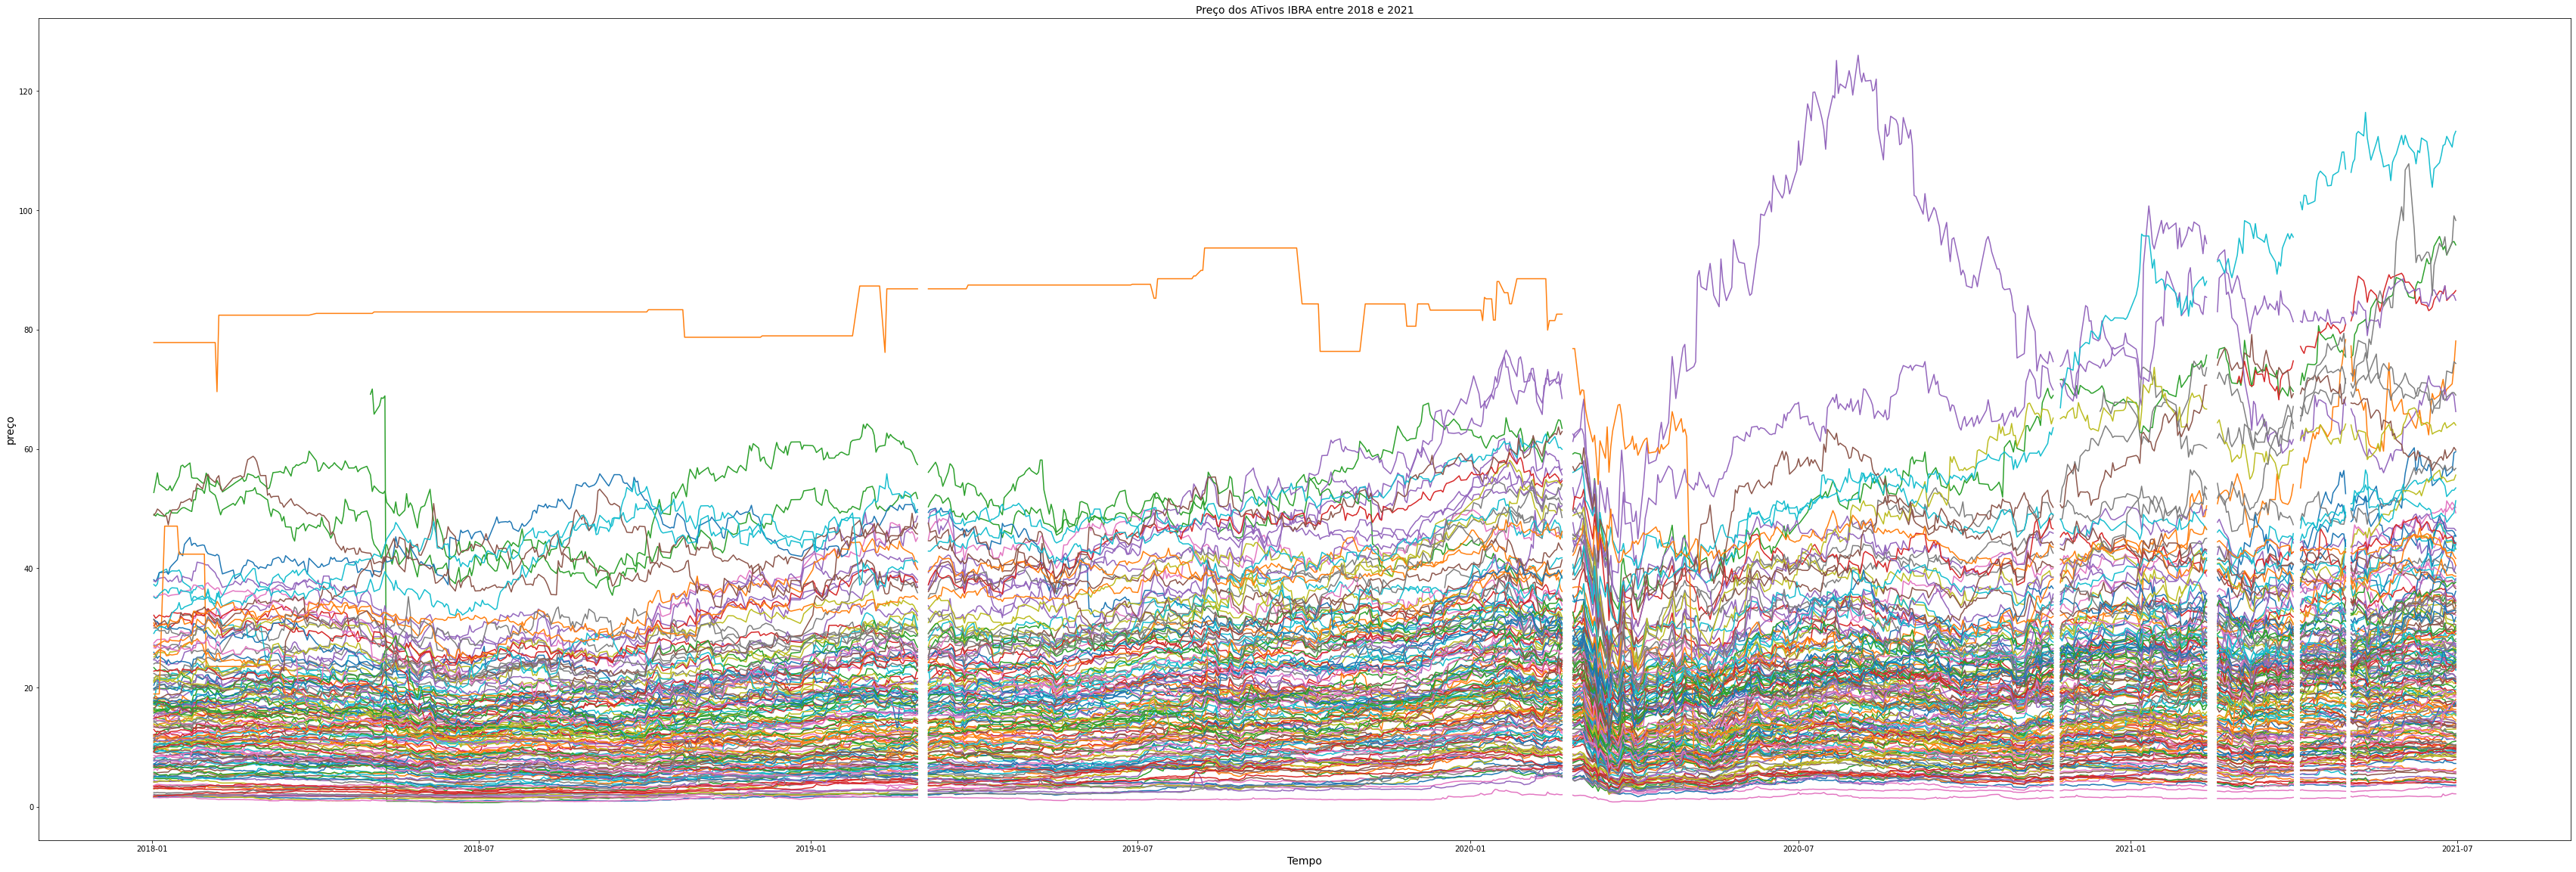

In [23]:
plt.figure(figsize=(60, 20))
plt.plot(dataset)
plt.xlabel('Tempo',fontsize=14)
plt.ylabel('preço',fontsize=14)
plt.title('Preço dos ATivos IBRA entre 2018 e 2021',fontsize=14)

#4. Preparação dos Dados
Para esta análise queremos agrupar os ativos de acordo com seu retorno anual e volatilidade. Para isto precisamos transformar a base para um dataframe contendo os ativos em linha com seu retorno e variancia em colunas. Além disso, como vimos, os ativos possuem preços bem divergentes, então precisamos padronizar a escala, pois a não padronização causaria uma distorção na analise. Outro ponto que devemos nos atentar antes da análise é fazer a limpeza dos dados, pois não podemos ter valores vazios no dataset.

### 4.1 Preparação dos dados

In [51]:
dataset.isnull().values.any()

True

In [62]:
#Removendo os ativos que possuem mais de 1% de valores faltando
missing_fractions = dataset.isnull().mean().sort_values(ascending=False)
drop_list = sorted(list(missing_fractions[missing_fractions > 0.01].index))
dataset.drop(labels=drop_list, axis=1, inplace=True)
dataset.shape

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


(866, 146)

In [63]:
# preenchendo os valores restantes com o valor da linha anterior
dataset=dataset.fillna(method='ffill')
dataset.head(2)

,AALR3.SA,ABCB4.SA,ABEV3.SA,AGRO3.SA,ALPA4.SA,ALSO3.SA,ALUP11.SA,AMAR3.SA,ANIM3.SA,ARZZ3.SA,AZUL4.SA,B3SA3.SA,BBAS3.SA,BBDC3.SA,BBDC4.SA,BBSE3.SA,BEEF3.SA,BKBR3.SA,BPAC11.SA,BPAN4.SA,BRAP4.SA,BRFS3.SA,BRKM5.SA,BRML3.SA,BRPR3.SA,BRSR6.SA,BTOW3.SA,CAML3.SA,CCRO3.SA,CESP6.SA,CIEL3.SA,CMIG3.SA,CMIG4.SA,COGN3.SA,CPFE3.SA,CPLE3.SA,CPLE6.SA,CRFB3.SA,CSAN3.SA,CSMG3.SA,...,QUAL3.SA,RADL3.SA,RAIL3.SA,RANI3.SA,RAPT4.SA,RCSL4.SA,RENT3.SA,ROMI3.SA,SANB11.SA,SAPR11.SA,SAPR4.SA,SBSP3.SA,SEER3.SA,SLCE3.SA,SMTO3.SA,SQIA3.SA,STBP3.SA,SULA11.SA,SUZB3.SA,TAEE11.SA,TASA4.SA,TCSA3.SA,TEND3.SA,TGMA3.SA,TIMS3.SA,TOTS3.SA,TRIS3.SA,TRPL4.SA,TUPY3.SA,UGPA3.SA,UNIP6.SA,USIM5.SA,VALE3.SA,VIVT3.SA,VLID3.SA,VULC3.SA,VVAR3.SA,WEGE3.SA,WIZS3.SA,YDUQ3.SA
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2018-01-02,14.74,13.700,19.845,11.014,13.623,23.959,16.258,7.79,9.389,52.693,27.15,6.783,27.436,17.854,20.857,21.278,9.731,17.547,4.155,1.737,24.785,37.27,38.076,11.447,9.974,11.800,19.768,7.001,14.437,10.673,19.798,4.939,4.821,17.506,15.905,1.606,1.854,14.215,9.794,10.420,...,25.568,17.642,12.99,1.86,6.867,1.569,21.001,4.678,26.981,16.547,3.129,31.416,26.666,10.279,17.759,6.566,3.398,15.229,18.298,14.677,2.10,21.1,9.282,17.286,11.860,9.744,1.802,11.483,16.589,35.326,11.076,9.256,35.182,30.851,17.312,9.29,7.699,9.183,8.607,29.988
2018-01-03,14.81,13.758,19.890,11.005,13.290,24.141,16.134,8.30,9.454,54.285,27.06,6.899,27.786,17.930,20.952,21.293,9.660,17.726,4.195,1.755,25.019,37.00,37.755,11.410,10.288,11.855,19.610,6.992,14.332,10.624,20.077,4.946,4.779,17.659,15.709,1.598,1.819,14.123,9.794,10.173,...,25.767,17.205,12.60,1.86,6.685,1.547,21.287,5.009,26.758,16.404,3.118,30.853,26.573,10.369,17.777,6.616,3.398,15.657,18.162,14.698,2.01,21.9,9.254,17.286,11.869,9.951,1.810,11.249,16.713,34.977,11.886,9.564,34.971,29.957,17.574,9.75,7.739,9.044,8.536,30.015


In [64]:
dataset.isnull().values.any()

False

Sucesso! Não temos mais valores faltando.

###4.2 Transformando os dados 
Para fazer o cluster iremos criar um novo dataframe contendo os ativos em linha e Retorno anual e Volatilidade como coluna.

In [65]:
#Calculando retorno médio anual e volatilidade em um periodo de um ano
returns = dataset.pct_change().mean() * 252
returns = pd.DataFrame(returns)
returns.columns = ['Returns']
returns['Volatility'] = dataset.pct_change().std() * np.sqrt(252)
data=returns

Todas as variaveis devem estar na mesma escala antes de aplicarmos a clusterização, caso contrário as discrepâncias de preço iriam dominar o resultado. Vamos usar o sklearn para padronizar o dataset em Z Scale (média=0 e desvio padrão = 1)


In [66]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler().fit(data)
rescaledDataset = pd.DataFrame(scaler.fit_transform(data),columns = data.columns, index = data.index)
# summarize transformed data
rescaledDataset.head(2)
X=rescaledDataset

In [67]:
X.head(2)

,Returns,Volatility
AALR3.SA,-1.061,-0.222
ABCB4.SA,-0.795,-1.042
